In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [4]:
columns = [
    "Severity", "State", "Temperature(F)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", 
    "Weather_Condition", "Sunrise_Sunset", "year", "date"
]

target = ["Severity"]

In [5]:
# Load the data
file_path = Path('PreCOVID_accidents.csv', index_col=False)
df = pd.read_csv(file_path)
df = df.loc[:, columns].copy()
df.head()

,Severity,State,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,year,date
0,long_delay,NJ,89.0,10.0,5.0,0.0,clear_weather,Day,2019,10/2/19
1,long_delay,LA,54.0,10.0,5.0,0.0,clear_weather,Day,2019,11/1/19
2,long_delay,AZ,41.0,10.0,10.0,0.0,clear_weather,Night,2020,2/16/20
3,long_delay,TX,79.0,10.0,25.0,0.0,bad_weather,Day,2019,6/4/19
4,long_delay,VA,37.0,10.0,0.0,0.0,clear_weather,Night,2019,10/19/19


In [6]:
# Check dtypes, features should be float64
df.dtypes


Severity              object
State                 object
Temperature(F)       float64
Visibility(mi)       float64
Wind_Speed(mph)      float64
Precipitation(in)    float64
Weather_Condition     object
Sunrise_Sunset        object
year                   int64
date                  object
dtype: object

In [7]:
# Get the number of rows
df.shape[0]

277041

In [8]:
# Drop NA rows
df = df.dropna(axis=0, how="any")
df.head()

,Severity,State,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Sunrise_Sunset,year,date
0,long_delay,NJ,89.0,10.0,5.0,0.0,clear_weather,Day,2019,10/2/19
1,long_delay,LA,54.0,10.0,5.0,0.0,clear_weather,Day,2019,11/1/19
2,long_delay,AZ,41.0,10.0,10.0,0.0,clear_weather,Night,2020,2/16/20
3,long_delay,TX,79.0,10.0,25.0,0.0,bad_weather,Day,2019,6/4/19
4,long_delay,VA,37.0,10.0,0.0,0.0,clear_weather,Night,2019,10/19/19


In [9]:
# Check the number of rows again; Data cleanup already dropped NAs
df.shape[0]

277041

In [10]:
# Get count of unique values in the 'Severity' column
print(df['Severity'].value_counts())

short_delay    228852
long_delay      48189
Name: Severity, dtype: int64


In [11]:
# Rename columns to get rid of () with measurement for plotting
df.rename(columns = {'Temperature(F)':'Temperature', 'Wind_Speed(mph)':'Wind_Speed', 'Precipitation(in)':'Precipitation', 'Visibility(mi)': 'Visibility'}, inplace = True)
df.head()                          

,Severity,State,Temperature,Visibility,Wind_Speed,Precipitation,Weather_Condition,Sunrise_Sunset,year,date
0,long_delay,NJ,89.0,10.0,5.0,0.0,clear_weather,Day,2019,10/2/19
1,long_delay,LA,54.0,10.0,5.0,0.0,clear_weather,Day,2019,11/1/19
2,long_delay,AZ,41.0,10.0,10.0,0.0,clear_weather,Night,2020,2/16/20
3,long_delay,TX,79.0,10.0,25.0,0.0,bad_weather,Day,2019,6/4/19
4,long_delay,VA,37.0,10.0,0.0,0.0,clear_weather,Night,2019,10/19/19


In [12]:
# Drop State, year and date columns to reduce factors for NOW
df.drop('State', axis=1, inplace=True)
df.drop('date', axis=1, inplace=True)
df.drop('year', axis=1, inplace=True)
df.head()

,Severity,Temperature,Visibility,Wind_Speed,Precipitation,Weather_Condition,Sunrise_Sunset
0,long_delay,89.0,10.0,5.0,0.0,clear_weather,Day
1,long_delay,54.0,10.0,5.0,0.0,clear_weather,Day
2,long_delay,41.0,10.0,10.0,0.0,clear_weather,Night
3,long_delay,79.0,10.0,25.0,0.0,bad_weather,Day
4,long_delay,37.0,10.0,0.0,0.0,clear_weather,Night


In [13]:
# Transform Sunrise_Sunset and Weather_Condition to binary feature
df.Sunrise_Sunset = df.Sunrise_Sunset.replace({'Day': 1, 'Night': 0}) 
df.Weather_Condition = df.Weather_Condition.replace({'clear_weather': 1, 'bad_weather': 0})
df.Severity = df.Severity.replace({'short_delay': 1, 'long_delay': 0})
df.head()

,Severity,Temperature,Visibility,Wind_Speed,Precipitation,Weather_Condition,Sunrise_Sunset
0,0,89.0,10.0,5.0,0.0,1,1
1,0,54.0,10.0,5.0,0.0,1,1
2,0,41.0,10.0,10.0,0.0,1,0
3,0,79.0,10.0,25.0,0.0,0,1
4,0,37.0,10.0,0.0,0.0,1,0


In [14]:
# Get count of unique values in the 'Weather_Condition' column
print(df['Weather_Condition'].value_counts())

1    228911
0     48130
Name: Weather_Condition, dtype: int64


In [15]:
# Calculate Correlations
df.corr()

,Severity,Temperature,Visibility,Wind_Speed,Precipitation,Weather_Condition,Sunrise_Sunset
Severity,1.000000,-0.042847,-0.030507,-0.081445,-0.026704,0.031673,0.014994
Temperature,-0.042847,1.000000,0.288617,-0.008902,-0.028550,0.282423,0.296735
Visibility,-0.030507,0.288617,1.000000,-0.017753,-0.198338,0.606688,0.057301
Wind_Speed,-0.081445,-0.008902,-0.017753,1.000000,0.056201,-0.119258,0.172319
Precipitation,-0.026704,-0.028550,-0.198338,0.056201,1.000000,-0.270177,-0.011266
Weather_Condition,0.031673,0.282423,0.606688,-0.119258,-0.270177,1.000000,0.039278
Sunrise_Sunset,0.014994,0.296735,0.057301,0.172319,-0.011266,0.039278,1.000000


## **SPLIT THE DATA INTO TRAINING AND TESTING - COVID YEARS**

In [16]:
# Create our target
y = df["Severity"]
X = df.drop(columns="Severity")

In [17]:
X.describe()

,Temperature,Visibility,Wind_Speed,Precipitation,Weather_Condition,Sunrise_Sunset
count,277041.000000,277041.000000,277041.000000,277041.000000,277041.000000,277041.000000
mean,58.705572,8.871667,6.973080,0.006797,0.826271,0.656267
std,18.713722,3.047073,5.532183,0.047183,0.378877,0.474954
min,-27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,10.000000,3.000000,0.000000,1.000000,0.000000
50%,60.000000,10.000000,6.000000,0.000000,1.000000,1.000000
75%,72.000000,10.000000,10.000000,0.000000,1.000000,1.000000
max,113.000000,90.000000,169.000000,9.990000,1.000000,1.000000


In [18]:
# Check the balance of our target values
y.value_counts()

1    228852
0     48189
Name: Severity, dtype: int64

In [19]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
#Counter(y_train)

### **Undersampling - PreCovid Years**

In [20]:
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()

<AxesSubplot:>

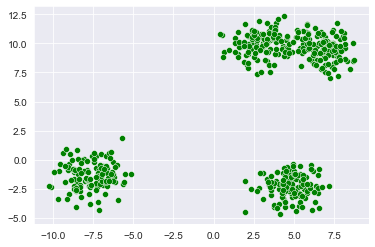

In [21]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
X, y = make_blobs(n_samples=500, centers=4, cluster_std = 1.00)
sns.scatterplot(x=X[:,0], y=X[:,1], c =["green"])

In [22]:
model = KMeans(n_clusters=4)
model.fit(X)

KMeans(n_clusters=4)

In [23]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
# import time 
# tic = time.time()

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import ClusterCentroids 
X, y = make_classification(n_classes=2, class_sep=2,
weights=[0.2, 0.8], flip_y=0,
n_features=6, n_clusters_per_class=1, n_samples=5000, random_state=42)
print('Original dataset shape %s' % Counter(y))
#Original dataset shape Counter({1: 900, 0: 100})
cc = ClusterCentroids(random_state=42)
X_res, y_res = cc.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

#Resampled dataset shape Counter({...})




Original dataset shape Counter({1: 4000, 0: 1000})
Resampled dataset shape Counter({0: 1000, 1: 1000})


In [24]:
# Train the Logistic Regression model using the resampled data

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=42)
model.fit(X_res, y_res)

LogisticRegression(random_state=42)

In [25]:
# Calculated the balanced accuracy score

#from sklearn.metrics import balanced_accuracy_score
#balanced_accuracy_score(y_test, y_train)

# Calculated the balanced accuracy score - CHECK
y_pred = model.predict(X)
balanced_accuracy_score(y, y_pred)

0.99675

In [26]:
# Display the confusion matrix
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X)
cm = confusion_matrix(y, y_pred)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual long_delay", "Actual short_delay"], columns=["Predicted long_delay", "Predicted short_delay"])
cm_df

,Predicted long_delay,Predicted short_delay
Actual long_delay,994,6
Actual short_delay,2,3998


In [27]:
# Print the imbalanced classification report

from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      1.00      1.00      1.00      0.99      1000
          1       1.00      1.00      0.99      1.00      1.00      0.99      4000

avg / total       1.00      1.00      1.00      1.00      1.00      0.99      5000

